In [76]:
n_rays = 100
case = "_Ex_7_2"

In [77]:
params = {
    "initialization": {
        "x_init": [2.5, 2.5],
        "y_init": [1.0, 1.5]
    },
    "exact":{
        "learning_rate": 0.009,
        "max_iters": 20000,
        "tol": 1e-5
    },
    "phase1": {
        "gamma": 12,
        "expo_gamma": 0.01,
        "max_iter": 10000,
        "tol": 1e-4
    },
    "phase2": {
        "expo_alpha": 0.45,
        "expo_beta": 0.4,
        "expo_lambda": 0.55,
        "init_params": 1.0,
        "max_iter": 2000,
        "mu": 1e-4,
        "verbose": False,
        "expo_gamma": 0.5
    }
}


In [78]:
import autograd.numpy as np
import torch

def set_seed(seed=702):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(702)

# Gen rays

In [79]:
import autograd.numpy as np
import math

In [80]:
def generate_chebyshev_rays(num_rays=10):
    rays = []
    angles = np.linspace(0, np.pi/2, num_rays)
    for theta in angles:
        r1, r2 = math.cos(theta), math.sin(theta)
        if abs(r1) < 1e-9: r1 = 0.0
        if abs(r2) < 1e-9: r2 = 0.0
        rays.append([r1, r2])       
    return np.array(rays)

In [81]:
test_rays = generate_chebyshev_rays(n_rays)

# Giải chính xác bằng phương pháp chiếu

## Bài toán

In [82]:
from scipy.optimize import Bounds

In [83]:
# ==========================================
# HÀM MỤC TIÊU
# ==========================================
def f1(x):    return (x[0]**2 + x[1]**2)/50
def f2(x):    return ((x[0] - 5)**2 + (x[1] - 5)**2)/50
def f(x):    return np.array([
    (x[0]**2 + x[1]**2)/50,
    ((x[0] - 5)**2 + (x[1] - 5)**2)/50])
def jacobian_f(x):
    return np.array([
        [x[0]/25.0, x[1]/25.0],
        [(x[0] - 5)/25.0, (x[1] - 5)/25.0]
    ])
# --- Hàm mục tiêu Weighted Chebyshev ---
def S_weighted_chebyshev(x, r, z):
    vals = f(x)
    weighted_diffs = r * np.abs(vals - z)
    return np.max(weighted_diffs)

def get_subgradient(x, r, z):
    vals = f(x)
    diffs = vals - z
    weighted_abs_diffs = r * np.abs(diffs)
    k = np.argmax(weighted_abs_diffs)
    
    J = jacobian_f(x)
    gradient_fk = J[k] 
    
    sign = 1.0 if diffs[k] >= 0 else -1.0
    grad = r[k] * sign * gradient_fk
    return grad
# ==========================================
# CÁC RÀNG BUỘC & PHÉP CHIẾU
# ==========================================
# Ràng buộc tập X
bounds_x = Bounds([0,0],[5, 5])
def constraints_X(x):
    # Trả về mảng các giá trị >= 0
    return np.array([
        x[0],           # x0 >= 0
        5.0 - x[0],     # x0 <= 5
        x[1],           # x1 >= 0
        5.0 - x[1]      # x1 <= 5
    ])

# --- Các ràng buộc tập Q ---
def q1(y): return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2
def q_plus(y):
    center = 0.4
    radius_sq = 0.2**2  
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

dim_x = 2
dim_y = 2

## Phép chiếu lên X'

In [84]:
from Problem import Problem
from project import Projection
from scipy.optimize import minimize

In [85]:
cons_C = ()
cons_Q = ({'type': 'ineq', 'fun' : q1,},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')
# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian_f],
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [86]:
def project_step(x_temp, y_temp, dim_x, dim_y):
    """
    Chiếu điểm (x, y) vào tập:
    { (x, y) | x in X, y in Q, f(x) <= y }
    """
    z_start = np.concatenate([x_temp, y_temp])
    
    def proj_obj(z): 
        return 0.5 * np.sum((z - z_start)**2)
    
    def proj_jac(z): 
        return z - z_start

    # Danh sách ràng buộc: scipy yêu cầu dạng 'ineq' (tức là >= 0)
    cons = [
        # Ràng buộc x \in X
        {'type': 'ineq', 'fun': lambda z: constraints_X(z[:dim_x])},
        # Ràng buộc y \in Q
        {'type': 'ineq', 'fun': lambda z: q1(z[dim_x:])},
        # Ràng buộc f(x) <= y  <=>  y - f(x) >= 0
        {'type': 'ineq', 'fun': lambda z: z[dim_x:] - f(z[:dim_x])}
    ]

    res = minimize(
        fun=proj_obj, x0=z_start, jac=proj_jac,
        constraints=cons, method='SLSQP',
        options={'disp': False}
    )
    
    if not res.success:
        return x_temp, y_temp
    return res.x[:dim_x], res.x[dim_x:]

## Core

In [87]:
def solve_weighted_chebyshev(r_pref, z_ref, params , dim_x=1, dim_y=2):
    x = params["initialization"]["x_init"]    
    y = params["initialization"]["y_init"]
    learning_rate = params["exact"]["learning_rate"]
    max_iters = params["exact"]["max_iters"]
    tol = params["exact"]["tol"]
    prev_obj_val = float('inf')
    converge = False
    
    print(f"r={r_pref}")
    print(f"{'Iter':<5} | {'x':<10} | {'y vector':<15} | {'Objective':<10} | {'Active Idx'}")
    for k in range(max_iters):
        # --- BƯỚC 1: Tính Subgradient ---
        grad_x = get_subgradient(x, r_pref, z_ref)
        
        # --- BƯỚC 2: Cập nhật biến x ---
        x_temp = x - learning_rate * grad_x
        y_temp = y 
        
        # --- BƯỚC 3: Phép chiếu (Projection) ---
        x_next, y_next = project_step(x_temp, y_temp, dim_x, dim_y)
        
        # --- Tính giá trị hàm mục tiêu hiện tại ---
        obj_val = S_weighted_chebyshev(x_next, r_pref, z_ref)
        
        # --- Logging ---
        diffs = r_pref * np.abs(f(x_next) - z_ref)
        active_idx = np.argmax(diffs)
        
        if k % 2000 == 0:
            print(f"{k:<5} | {x_next[0]:.4f}     | [{y_next[0]:.2f}, {y_next[1]:.2f}] | {obj_val:.6f}     | f_{active_idx+1}")

        # --- BƯỚC 4: Kiểm tra điều kiện dừng ---
        loss_change = abs(prev_obj_val - obj_val)
        
        if loss_change < tol:
            print(f"--> Hội tụ tại bước {k}!\n")
            converge = True
            break
            
        prev_obj_val = obj_val
        x = x_next
        y = y_next

    return x, y, converge

## Tìm điểm tham chiếu

In [88]:
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal

In [89]:
def relevant_point(prob, params):
    x_feasible, _, _, _ = solve_CQ_feasible(
        prob.objective_func, prob.jacobian, prob.proj_C, prob.proj_Qplus,
        x0=params['initialization']['x_init'],
        gamma=params['phase1']['gamma'] , max_iter=params['phase1']['max_iter']
    )

    z_vals = []
    nadir_vals = []

    for dim in range(2):
        # Tìm MIN
        x_min, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="min", max_iter=500, mu=0.001)
        val_min = prob.objective_func(x_min)[dim]
        z_vals.append(val_min)

        # Tìm MAX 
        x_max, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="max", max_iter=500, mu=0.001)
        val_max = prob.objective_func(x_max)[dim]
        nadir_vals.append(val_max)
        print(f"   Dim {dim}: Min={val_min:.4f}, Max={val_max:.4f}")
    z_star = np.array(z_vals)
    ref_point = np.array(nadir_vals) + np.abs(np.array(nadir_vals)) * 0.1 + 0.5 
    print(f"-> Z* (Ideal): {z_star}")
    print(f"-> Ref Point (HV): {ref_point}")
    print(f"-> x (Feasible): {x_feasible}")
    return z_star, ref_point, x_feasible

## Giải chính xác

In [90]:
z_star, ref_point, x_feasible = relevant_point(prob, params)

Khởi tạo: x0: [2.5, 2.5]
Chiếu lên C được: x: [2.5 2.5]


  0%|          | 0/10000 [00:00<?, ?it/s]


Hội tụ tại vòng lặp 0
+---+------------+---------+--------------+--------------+----------+----------+
| k | x_new      | gamma_k | y            | z_proj       |   e_x    |   e_f    |
+---+------------+---------+--------------+--------------+----------+----------+
| 0 | [2.5, 2.5] | 12.0000 | [0.25, 0.25] | [0.25, 0.25] | 0.000000 | 0.000000 |
+---+------------+---------+--------------+--------------+----------+----------+


   Dim 0: Min=0.0374, Max=0.8115
   Dim 1: Min=0.0374, Max=0.8115
-> Z* (Ideal): [0.0374 0.0374]
-> Ref Point (HV): [1.3927 1.3927]
-> x (Feasible): [2.5 2.5]


In [91]:
pf_true = []
converge = 0
for r in test_rays:
    x, y, conv = solve_weighted_chebyshev(
        r_pref=r,
        z_ref=z_star, 
        dim_x=dim_x, 
        dim_y=dim_y,
        params=params)
    if conv:
        converge += 1
    pf_true.append(f(x))
print(f"Converge rate = {100*converge/len(test_rays)}%")

r=[1. 0.]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.4991     | [0.50, 0.58] | 0.212440     | f_1
2000  | 1.2163     | [0.50, 0.58] | 0.021794     | f_1
--> Hội tụ tại bước 2297!

r=[0.9999 0.0159]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.4991     | [0.50, 0.58] | 0.212414     | f_1
2000  | 1.2164     | [0.50, 0.58] | 0.021802     | f_1
--> Hội tụ tại bước 2298!

r=[0.9995 0.0317]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.4991     | [0.50, 0.58] | 0.212334     | f_1
2000  | 1.2167     | [0.50, 0.58] | 0.021826     | f_1
--> Hội tụ tại bước 2131!

r=[0.9989 0.0476]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.4991     | [0.50, 0.58] | 0.212200     | f_1
--> Hội tụ tại bước 1929!

r=[0.998  0.0634]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.4991     | [0.50, 0.58] | 0.212013     | f_1
--> Hội tụ tại bước 1782!

r=[0.9969 0.0792]
Iter  | x 

--> Hội tụ tại bước 148!

r=[0.6901 0.7237]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.153786     | f_2
--> Hội tụ tại bước 75!

r=[0.6785 0.7346]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.156092     | f_2
--> Hội tụ tại bước 101!

r=[0.6668 0.7453]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.158358     | f_2
--> Hội tụ tại bước 110!

r=[0.6549 0.7557]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.160585     | f_2
--> Hội tụ tại bước 116!

r=[0.6428 0.766 ]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.162771     | f_2
--> Hội tụ tại bước 141!

r=[0.6306 0.7761]
Iter  | x          | y vector        | Objective  | Active Idx
0     | 2.5007     | [0.50, 0.58] | 0.164916     | f_2
--> Hội tụ tại bước 161!

r=[

# Giải xấp xỉ dynamic

## Tuning

In [99]:
import itertools
from tqdm import tqdm
from Phase2_dynamic import optim_Scalarization
from evaluate import get_metrics
import pandas as pd

def generate_valid_params():
    grid = {
        'expo_lambda': [0.7, 0.8, 0.9],
        'expo_alpha':  [0.05, 0.1, 0.2], 
        'expo_beta':   [0.3],
        'expo_gamma':  [0.5],
        'init_params': [0.5],
        'mu': [0.0001],
        'max_iter' : [5000]
    }
    keys, values = zip(*grid.items())
    raw_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    valid_combinations = []
    for p in raw_combinations:
        # --- KIỂM TRA ĐIỀU KIỆN ---
        cond1 = 0.5 < p['expo_lambda'] <= 1.0
        cond2 = p['expo_lambda'] + p['expo_alpha'] <= 1
        cond3 = p['expo_beta'] < p['expo_lambda']
        cond4 = p['expo_gamma'] < p['expo_lambda']
        if cond1 and cond2 and cond3 and cond4:
            valid_combinations.append(p)  
    return valid_combinations

def tuning_dynamic(prob, z_star, x_feasible, pf_true, ref_point, test_rays):
    param_combinations = generate_valid_params()
    results_log = []

    print(f"=== GRID SEARCH: ƯU TIÊN MED ===")
    print(f"Số lượng cấu hình: {len(param_combinations)} | Số tia: {len(test_rays)}")

    for idx, params in tqdm(enumerate(param_combinations)):
        pareto_f_temp = []
        for r in test_rays:
            x_final, _ = optim_Scalarization(
                prob=prob,
                x_feasible=x_feasible,  
                r=r, 
                z_star=z_star,
                verbose=False,
                **params 
            )
            pareto_f_temp.append(prob.objective_func(x_final))
        med, hv = get_metrics(pareto_f_temp, pf_true, prob, ref_point)

        log_entry = {
            'params': params,
            'MED': med,
            'HV': hv,
            'id': idx
        }
        results_log.append(log_entry)

        print(f"[{idx:02d}] MED: {med:.6e} | HV: {hv:.6f}")
    best_entry = min(results_log, key=lambda x: x['MED'])
    print("\n" + "="*60)
    print(f"CẤU HÌNH TỐI ƯU NHẤT THEO MED:")
    print(f"ID: {best_entry['id']}")
    print(f"MED: {best_entry['MED']:.6f}, HV {best_entry['HV']}")
    print(f"Params: {best_entry['params']}")
    print("="*60)
    df = pd.json_normalize(results_log, sep='_')
    df.columns = df.columns.str.replace('params_', '')
    
    return best_entry['params'], df

In [ ]:
best_params, df = tuning_dynamic(
    prob, z_star, x_feasible, pf_true, ref_point, test_rays
)

=== GRID SEARCH: ƯU TIÊN MED ===
Số lượng cấu hình: 8 | Số tia: 100


0it [00:00, ?it/s]

!! Max_iter. Delta: 0.000081, Gap C: 0.000000, Gap Q: 0.002649
!! Max_iter. Delta: 0.000081, Gap C: 0.000000, Gap Q: 0.002647
-> Hội tụ sớm tại k=4194.
!! Max_iter. Delta: 0.000013, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000017, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000021, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000025, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000108, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000111, Gap C: 0.000000, Gap Q: 0.000000
-> Hội tụ sớm tại k=43.
!! Max_iter. Delta: 0.000116, Gap C: 0.000000, Gap Q: 0.000000


In [ ]:
df.to_csv(f"exp/{case}/{n_rays}_tuning_dynamic.csv", index=False)

In [ ]:
df.sort_values("MED")

In [94]:
df.groupby("expo_lambda")[["MED", "HV"]].agg(["mean", "min", "max"]).reset_index()

expo_lambda       MED                            HV                    
                   mean       min       max      mean       min       max
0        0.51  0.003620  0.002529  0.004931  1.695227  1.676876  1.701247
1        0.65  0.002379  0.001865  0.002869  1.699081  1.695425  1.701490
2        0.80  0.001227  0.000713  0.001827  1.695807  1.695044  1.698203

In [97]:
df.groupby("mu")[["MED", "HV"]].agg(["mean", "min", "max"]).reset_index()

mu       MED                            HV                    
               mean       min       max      mean       min       max
0  0.0001  0.002552  0.000713  0.003765  1.698075  1.694546  1.701478
1  0.0100  0.003063  0.000818  0.004931  1.695141  1.676876  1.701490

In [98]:
df.groupby("expo_alpha")[["MED", "HV"]].agg(["mean", "min", "max"]).reset_index()

expo_alpha       MED                            HV                    
                  mean       min       max      mean       min       max
0       0.10  0.002481  0.000713  0.004715  1.697178  1.687884  1.701478
1       0.25  0.002792  0.001865  0.004503  1.696507  1.676876  1.701490
2       0.40  0.003816  0.002725  0.004931  1.695102  1.677650  1.701062

In [ ]:
best_params

## Best

In [ ]:
from Phase2_dynamic import optim_Scalarization
from evaluate import get_metrics

In [ ]:
pf_true_dynamic = []
for r in test_rays:
        x_final, _ = optim_Scalarization(
            prob=prob,
            x_feasible=x_feasible,  
            r=r, 
            z_star=z_star,
            # Các tham số tĩnh
            verbose=True,
            # --- CÁC THAM SỐ ĐANG TỐI ƯU ---
            max_iter=best_params['max_iter'],
            mu=best_params['mu'],
            init_params=best_params['init_params'],
            expo_alpha=best_params['expo_alpha'],
            expo_lambda=best_params['expo_lambda'],
            expo_beta=best_params['expo_beta'],
            expo_gamma=best_params['expo_gamma'],
        )
        pf_true_dynamic.append(prob.objective_func(x_final))
    
med, hv = get_metrics(pf_true_dynamic, pf_true, prob, ref_point)

In [ ]:
med, hv

## Viz

In [20]:
from utils import visualize_pareto_front, generate_pareto_grid

In [21]:
def generate_pareto_grid(f_func, c_funcs, q_plus_func, resolution=400):
    """
    Sinh dữ liệu Pareto cho bài toán 2D bằng cách quét lưới tọa độ.
    f_func: Hàm mục tiêu f(x)
    c_funcs: Danh sách các hàm ràng buộc c(x) >= 0 (miền C)
    q_plus_func: Hàm ràng buộc q_plus(y) >= 0 (miền Q+)
    """
    print(f"--- Đang quét lưới {resolution}x{resolution} điểm ---")
    
    # 1. Xác định phạm vi quét dựa trên các ràng buộc hình tròn c1, c2

    x0_range = np.linspace(0, 5, resolution)
    x1_range = np.linspace(0, 5, resolution)
    X0, X1 = np.meshgrid(x0_range, x1_range)
    
    # Làm phẳng để tính toán vector
    points_X = np.vstack([X0.ravel(), X1.ravel()]).T
    
    # 2. Kiểm tra ràng buộc miền C: c1(x) >= 0 và c2(x) >= 0
    # (Sử dụng các hàm c1, c2 đã định nghĩa của bạn)
    mask_C = np.ones(len(points_X), dtype=bool)
    for c_func in c_funcs:
        mask_C &= (c_func(points_X.T) >= 0)
    
    feasible_X = points_X[mask_C]
    print(f"-> Tìm thấy {len(feasible_X)} điểm thỏa mãn miền C.")
    
    if len(feasible_X) == 0:
        return None, None

    # 3. Tính giá trị mục tiêu f(x) và kiểm tra miền Q+
    f_vals = np.array([f_func(x) for x in feasible_X])  # shape (N, 2)
    
    # Kiểm tra q_plus(f(x)) >= 0
    # Lưu ý: Hàm q_plus của bạn nhận 1 vector y, ta cần áp dụng cho toàn bộ f_vals
    mask_Qplus = np.array([q_plus_func(y) >= 0 for y in f_vals])
    
    pf_cloud_data = f_vals[mask_Qplus]
    print(f"-> Lọc còn {len(pf_cloud_data)} điểm thỏa mãn Q+ (Cloud).")

    if len(pf_cloud_data) == 0:
        return None, None

    # 4. Lọc Pareto Front từ Cloud (Tìm các điểm không bị trội)
    # Sắp xếp theo f1 tăng dần
    sorted_indices = np.argsort(pf_cloud_data[:, 0])
    y_sorted = pf_cloud_data[sorted_indices]
    
    pareto_list = []
    pareto_list.append(y_sorted[0])
    current_min_f2 = y_sorted[0][1]
    
    for i in range(1, len(y_sorted)):
        if y_sorted[i][1] < current_min_f2:
            pareto_list.append(y_sorted[i])
            current_min_f2 = y_sorted[i][1]
    
    pf_targets_data = np.array(pareto_list)
    print(f"-> Kết quả: {len(pf_targets_data)} điểm Pareto.")
    
    return pf_cloud_data, pf_targets_data

In [22]:
def non_c(x):
    return 1
pf_cloud, pf_targets = generate_pareto_grid(
    f_func=f, 
    c_funcs=[non_c], 
    q_plus_func=q_plus, 
    resolution=500
)

--- Đang quét lưới 500x500 điểm ---
-> Tìm thấy 250000 điểm thỏa mãn miền C.
-> Lọc còn 192206 điểm thỏa mãn Q+ (Cloud).
-> Kết quả: 549 điểm Pareto.


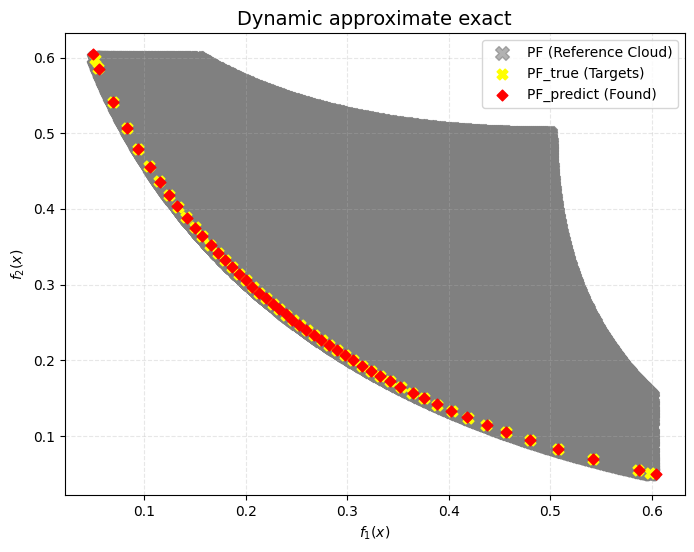

In [23]:
visualize_pareto_front(
    pf_pred=np.array(pf_true_dynamic), 
    pf_cloud=pf_cloud,   
    pf_targets=np.array(pf_true),
    title="Dynamic approximate exact",
    figsize=(8, 6)
)

# Hypernet

In [ ]:
from training_hypernet import train_hypernet

In [ ]:
prob_ = Problem(
    f=[f1, f2], jac_f=[jacobian_f],
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

## Tuning

In [ ]:
from tuning_hypernet import run_hypernet_tuning

In [51]:
param_grid = {
    'lr': [1e-3],
    'num_epochs': [1000, 2000],
    
    'num_partitions': [n_rays],
    
    # Tham số thuật toán 2-A: Tăng dần penalty
    'beta_C_0': [10],
    'beta_Q_0': [1, 5],
    'rho_C': [1.01], 
    'rho_Q': [1.01, 1.001],
    
    # Cố định Max để tránh grid quá lớn 
    'beta_C_max': [1000.0],
    'beta_Q_max': [50.0, 100.0, 200.0]
}

In [52]:
device = 'cpu'

In [53]:
results = run_hypernet_tuning(
    prob=prob_,
    dim_x=dim_x,
    z_star=z_star,
    ref_point=ref_point,
    test_rays=test_rays,
    pf_true=pf_true,
    param_grid=param_grid,
    indicator="MED", 
    device=device,
    save_dir=f"model/{case}",
    train_func=train_hypernet
)


🔹 TUNING MODEL: MLP | PRIORITY: MED

>>> [Config 1/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 1, 'rho_C': 1.01, 'rho_Q': 1.01, 'beta_C_max': 1000.0, 'beta_Q_max': 50.0}
      ⏱️ Time: 148.1s | 📏 MED: 0.003445 | 📈 HV: 1.693190
      🏆 NEW BEST FOUND! Saved to: model/_Ex_7_2/best_MLP_MED.pth

>>> [Config 2/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 1, 'rho_C': 1.01, 'rho_Q': 1.01, 'beta_C_max': 1000.0, 'beta_Q_max': 100.0}
      ⏱️ Time: 145.2s | 📏 MED: 0.008428 | 📈 HV: 1.678370

>>> [Config 3/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 1, 'rho_C': 1.01, 'rho_Q': 1.01, 'beta_C_max': 1000.0, 'beta_Q_max': 200.0}
      ⏱️ Time: 146.3s | 📏 MED: 0.015082 | 📈 HV: 1.662164

>>> [Config 4/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 1, 'rho_C': 1.01, 'rho_Q': 1.001, 'beta_C_max': 1000.0, 

      ⏱️ Time: 178.1s | 📏 MED: 0.005559 | 📈 HV: 1.684007

>>> [Config 8/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 5, 'rho_C': 1.01, 'rho_Q': 1.01, 'beta_C_max': 1000.0, 'beta_Q_max': 100.0}
      ⏱️ Time: 177.0s | 📏 MED: 0.006687 | 📈 HV: 1.685447

>>> [Config 9/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 5, 'rho_C': 1.01, 'rho_Q': 1.01, 'beta_C_max': 1000.0, 'beta_Q_max': 200.0}
      ⏱️ Time: 174.5s | 📏 MED: 0.004243 | 📈 HV: 1.691587

>>> [Config 10/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 5, 'rho_C': 1.01, 'rho_Q': 1.001, 'beta_C_max': 1000.0, 'beta_Q_max': 50.0}
      ⏱️ Time: 176.2s | 📏 MED: 0.004066 | 📈 HV: 1.693939

>>> [Config 11/24] Params: {'lr': 0.001, 'num_epochs': 1000, 'num_partitions': 50, 'beta_C_0': 10, 'beta_Q_0': 5, 'rho_C': 1.01, 'rho_Q': 1.001, 'beta_C_max': 1000.0, 'beta_Q_max': 100.0}
      ⏱️ Time: 175.3s

# Viz

In [54]:
import pandas as pd

In [55]:
df = pd.json_normalize(results, sep='_')
df.columns = df.columns.str.replace('params_', '')

In [56]:
df.sort_values("med")

,model,med,hv,time,lr,num_epochs,num_partitions,beta_C_0,beta_Q_0,rho_C,rho_Q,beta_C_max,beta_Q_max
35,trans,0.001953,1.697809,175.093060,0.001,1000,50,10,5,1.01,1.001,1000.0,200.0
38,trans,0.002164,1.691114,348.846488,0.001,2000,50,10,1,1.01,1.010,1000.0,200.0
28,trans,0.002739,1.695942,177.401680,0.001,1000,50,10,1,1.01,1.001,1000.0,100.0
25,trans,0.002858,1.694996,175.677555,0.001,1000,50,10,1,1.01,1.010,1000.0,100.0
41,trans,0.002916,1.691995,349.909663,0.001,2000,50,10,1,1.01,1.001,1000.0,200.0
40,trans,0.003328,1.694975,350.565628,0.001,2000,50,10,1,1.01,1.001,1000.0,100.0
46,trans,0.003344,1.691755,345.793741,0.001,2000,50,10,5,1.01,1.001,1000.0,100.0
0,MLP,0.003445,1.693190,148.078649,0.001,1000,50,10,1,1.01,1.010,1000.0,50.0
37,trans,0.003505,1.691484,349.016245,0.001,2000,50,10,1,1.01,1.010,1000.0,100.0
47,trans,0.003560,1.693740,345.472591,0.001,2000,50,10,5,1.01,1.001,1000.0,200.0


In [57]:
 df.groupby("beta_Q_max")[["med", "hv"]].agg(["mean", "min", "max"]).reset_index()

beta_Q_max       med                            hv                    
                  mean       min       max      mean       min       max
0       50.0  0.007755  0.003445  0.023099  1.683051  1.643693  1.696370
1      100.0  0.006950  0.002739  0.017388  1.684553  1.656642  1.698336
2      200.0  0.006333  0.001953  0.015082  1.686551  1.661682  1.699252

In [58]:
 df.groupby("num_epochs")[["med", "hv"]].agg(["mean", "min", "max"]).reset_index()

num_epochs       med                            hv                    
                  mean       min       max      mean       min       max
0       1000  0.007788  0.001953  0.023099  1.682455  1.643693  1.699252
1       2000  0.006237  0.002164  0.014382  1.686981  1.661682  1.698622

In [59]:
 df.groupby("lr")[["med", "hv"]].agg(["mean", "min", "max"]).reset_index()

lr       med                            hv                    
              mean       min       max      mean       min       max
0  0.001  0.007013  0.001953  0.023099  1.684718  1.643693  1.699252

In [60]:
 df.groupby("rho_Q")[["med", "hv"]].agg(["mean", "min", "max"]).reset_index()

rho_Q       med                            hv                    
              mean       min       max      mean       min       max
0  1.001  0.006754  0.001953  0.017976  1.685116  1.649548  1.698336
1  1.010  0.007271  0.002164  0.023099  1.684320  1.643693  1.699252

In [61]:
old_df = pd.read_csv("exp/_Ex_7_2/50_tuning_dynamic.csv")
old_df

,MED,HV,id,expo_lambda,expo_alpha,expo_beta,expo_gamma,init_params,mu,max_iter
0,0.003765,1.694546,0,0.51,0.1,0.3,0.3,1.0,0.0001,1000
1,0.004576,1.697559,1,0.51,0.1,0.3,0.3,1.0,0.0100,1000
2,0.003252,1.700259,2,0.51,0.1,0.3,0.3,2.0,0.0001,1000
3,0.003933,1.701113,3,0.51,0.1,0.3,0.3,2.0,0.0100,1000
4,0.003450,1.694546,4,0.51,0.1,0.3,0.5,1.0,0.0001,1000
...,...,...,...,...,...,...,...,...,...,...
91,0.001827,1.698203,91,0.80,0.1,0.5,0.3,2.0,0.0100,1000
92,0.000713,1.695070,92,0.80,0.1,0.5,0.5,1.0,0.0001,1000
93,0.000818,1.696158,93,0.80,0.1,0.5,0.5,1.0,0.0100,1000
94,0.001067,1.695044,94,0.80,0.1,0.5,0.5,2.0,0.0001,1000


In [63]:
df = pd.concat([df, old_df])

In [65]:
df.to_csv(f"exp/{case}/{n_rays}_Tuning_hnet.csv", index=False)

## Infer

In [66]:
import os
import torch
import time
from hypernet_MLP import Hypernet_MLP
from hypernet_trans import Hypernet_trans
from utils import plot_trajectories

In [67]:
def infer(model, test_rays=test_rays):
    model.eval()
    pf_pred = [] 
    tmp_err = [] 
    t1 = time.time()
    print(f"Evaluating on {len(test_rays)} rays...")

    for r in test_rays:   
        # --- Dự đoán với Hypernetwork ---
        ray_t = torch.from_numpy(r).float().unsqueeze(0)
        with torch.no_grad(): 
            output_x = model(ray_t).flatten() 
            vals = [func(output_x).item() for func in prob_.f]
            obj_pred = np.array(vals)

        pf_pred.append(obj_pred)
    t2 = time.time()
    pf_pred = np.array(pf_pred)
    print("-" * 30)
    print(f"Inference Time: {t2-t1:.4f}s")
    return pf_pred

In [68]:
best_MLP = Hypernet_MLP(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
best_trans = Hypernet_trans(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
# 2. Đường dẫn file đã lưu
PATH_MLP = f"model/{case}/best_MLP_MED.pth"
PATH_trans = f"model/{case}/best_trans_MED.pth"
# 3. Load state dict
if os.path.exists(PATH_MLP):
    state_dict = torch.load(PATH_MLP, map_location=device)
    best_MLP.load_state_dict(state_dict)
    best_MLP.to(device)
    best_MLP.eval() 
    print("Successful MLP ✅")

if os.path.exists(PATH_trans):
    state_dict = torch.load(PATH_trans, map_location=device)
    best_trans.load_state_dict(state_dict)
    best_trans.to(device)
    best_trans.eval() 
    print("Successful Trans ✅")

Successful MLP ✅
Successful Trans ✅


In [69]:
pf_pred = infer(best_trans)
med, hv = get_metrics(pf_pred, pf_true, prob_, ref_point)
med, hv

Evaluating on 50 rays...
------------------------------
Inference Time: 0.0210s


(np.float64(0.0019531144157117872), np.float64(1.697809143713242))

<Figure size 1600x800 with 0 Axes>

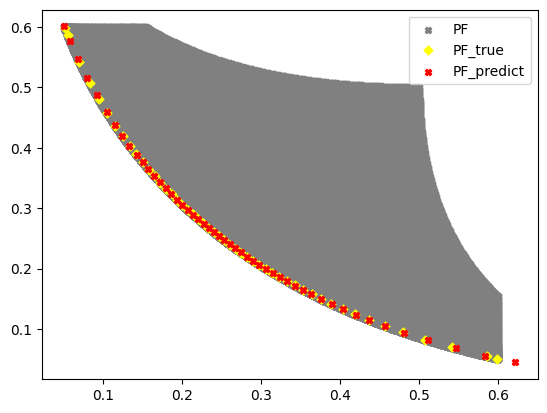

In [70]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=pf_cloud , figsize=(16, 8))

In [71]:
pf_pred = infer(best_MLP)
med, hv = get_metrics(pf_pred, pf_true, prob, ref_point)
med, hv

Evaluating on 50 rays...
------------------------------
Inference Time: 0.0063s


(np.float64(0.0034447242629177016), np.float64(1.6931900506771749))

<Figure size 1600x800 with 0 Axes>

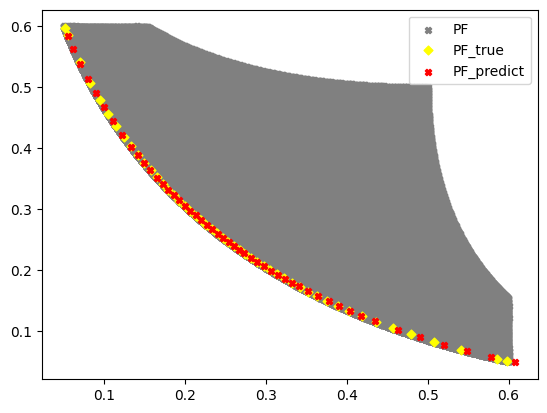

In [72]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=pf_cloud , figsize=(16, 8))

# Summarize

In [73]:
def run_benchmark(
    name,               # Tên hiển thị trong CSV (vd: "Hypernet_MLP", "Solver_BestParams")
    method_type,        # "model" hoặc "solver"
    prob,               # Đối tượng bài toán
    test_rays,          # Tập tia kiểm tra
    pf_true_gt,         # Ground Truth chuẩn để tính MED
    ref_point,          # Điểm tham chiếu tính HV
    # --- Optional cho Model ---
    model=None,
    # --- Optional cho Solver ---
    solver_func=None,
    x_feasible=None,
    z_star=None,
    solver_params=None, # Dictionary chứa {mu, max_iter, ...}
    # --- Settings ---
    csv_path="results_summary.csv",
    n_runs=None         # Số lần chạy để tính trung bình time (Mặc định: Model=10, Solver=1)
):
    """
    Hàm benchmark tổng hợp cho cả AI Model và Numerical Solver.
    """
    num_rays = len(test_rays)
    
    # 1. Xác định số lần chạy mặc định nếu không truyền vào
    if n_runs is None:
        n_runs = 10 if method_type == "model" else 1
    
    # 2. KIỂM TRA TRÙNG LẶP TRONG CSV
    if os.path.exists(csv_path):
        try:
            df_check = pd.read_csv(csv_path)
            is_exist = not df_check[(df_check['model'] == name) & 
                                    (df_check['num_rays'] == num_rays)].empty
            if is_exist:
                print(f"⚠️  [EXIST] Kết quả '{name}' ({num_rays} rays) đã có.")
                user_resp = input("   Chạy lại? (y/n): ").strip().lower()
                if user_resp != 'y':
                    return df_check
        except: pass

    print(f"\n🚀 BENCHMARKING: {name}")
    print(f"   Type: {method_type} | Rays: {num_rays} | Repeats: {n_runs}")

    # 3. CHUẨN BỊ (Warm-up cho Model)
    device = None
    if method_type == "model" and model is not None:
        model.eval()
        device = next(model.parameters()).device
        # Warm-up 1 pass
        dummy_ray = torch.from_numpy(test_rays[0]).float().unsqueeze(0).to(device)
        with torch.no_grad(): _ = model(dummy_ray)

    # 4. ĐO THỜI GIAN VÀ CHẠY
    total_time = 0
    pf_pred_final = []

    for i in range(n_runs):
        t1 = time.time()
        current_pf_vals = []

        # --- CASE A: DEEP LEARNING MODEL ---
        if method_type == "model":
            for r in test_rays:
                ray_t = torch.from_numpy(r).float().unsqueeze(0).to(device)
                with torch.no_grad():
                    output_x = model(ray_t).flatten()
                    x_cpu = output_x.cpu().numpy()
                    vals = [func(x_cpu).item() for func in prob.f]
                    current_pf_vals.append(vals)
        
        # --- CASE B: NUMERICAL SOLVER ---
        elif method_type == "solver":
            for r in test_rays:
                # Gọi solver với tham số unpack từ dict
                x_final, _ = solver_func(
                    prob=prob,
                    x_feasible=x_feasible,
                    r=r,
                    z_star=z_star,
                    verbose=False, # Tắt log chi tiết khi benchmark
                    max_iter=solver_params['max_iter'],
                    mu=solver_params['mu'],
                    init_params=solver_params['init_params'],
                    expo_alpha=solver_params['expo_alpha'],
                    expo_lambda=solver_params['expo_lambda'],
                    expo_beta=solver_params['expo_beta'],
                    expo_gamma=solver_params['expo_gamma']
                )
                current_pf_vals.append(prob.objective_func(x_final))
        
        t2 = time.time()
        run_time = t2 - t1
        total_time += run_time
        
        # In tiến độ nếu chạy Solver (vì lâu)
        if method_type == "solver":
            print(f"   Run {i+1}/{n_runs}: {run_time:.4f}s")
        
        # Lưu kết quả của lần chạy cuối cùng
        if i == n_runs - 1:
            pf_pred_final = np.array(current_pf_vals)

    avg_time = total_time / n_runs
    print(f"   ⏱️ Avg Time: {avg_time:.4f}s")

    # 5. TÍNH METRICS & LƯU
    med, hv = get_metrics(pf_pred_final, pf_true_gt, prob, ref_point)
    print(f"   📊 MED: {med:.5f} | HV: {hv:.5f}")

    new_row = {
        "model": name,
        "num_rays": num_rays,
        "med": med,
        "hv": hv,
        "time": avg_time
    }
    
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    else:
        df = pd.DataFrame([new_row])
        
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved to {csv_path}")
    return df

In [75]:
csv_file = f"exp/{case}/{n_rays}_conclusion.csv"

# 1. Benchmark Hypernetwork MLP
run_benchmark(
    name="Hypernet_MLP",
    method_type="model",
    prob=prob_,
    test_rays=test_rays,
    pf_true_gt=pf_true,      # Ground Truth chuẩn
    ref_point=ref_point,
    model=best_MLP,          # Truyền model vào
    csv_path=csv_file
)

# 2. Benchmark Hypernetwork Transformer
run_benchmark(
    name="Hypernet_Trans",
    method_type="model",
    prob=prob_,
    test_rays=test_rays,
    pf_true_gt=pf_true,
    ref_point=ref_point,
    model=best_trans,        # Truyền model vào
    csv_path=csv_file
)

# 3. Benchmark Numerical Solver (Với tham số tốt nhất)
run_benchmark(
    name="Numerical_Solver",
    method_type="solver",
    prob=prob,
    test_rays=test_rays,
    pf_true_gt=pf_true,
    ref_point=ref_point,
    solver_func=optim_Scalarization,  # Truyền hàm giải
    x_feasible=x_feasible,            # Input cần thiết cho solver
    z_star=z_star,                    # Input cần thiết cho solver
    solver_params=best_params,        # Dictionary chứa {mu, expo_alpha...} từ GridSearch
    csv_path=csv_file,
    n_runs=1                          # Chạy 1 lần vì lâu
)


🚀 BENCHMARKING: Hypernet_MLP
   Type: model | Rays: 50 | Repeats: 10
   ⏱️ Avg Time: 0.0028s
   📊 MED: 0.00344 | HV: 1.69319
✅ Saved to exp/_Ex_7_2/50_conclusion.csv

🚀 BENCHMARKING: Hypernet_Trans
   Type: model | Rays: 50 | Repeats: 10
   ⏱️ Avg Time: 0.0148s
   📊 MED: 0.00195 | HV: 1.69781
✅ Saved to exp/_Ex_7_2/50_conclusion.csv

🚀 BENCHMARKING: Numerical_Solver
   Type: solver | Rays: 50 | Repeats: 1
!! Max_iter. Delta: 0.000251, Gap C: 0.000000, Gap Q: 0.005160
!! Max_iter. Delta: 0.000264, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000053, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000077, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000100, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000361, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000376, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000162, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.000182, Gap C: 0.000000, Gap Q: 0.000000
!! Max_iter. Delta: 0.0

,model,num_rays,med,hv,time
0,Hypernet_MLP,50,0.003445,1.693190,0.002842
1,Hypernet_Trans,50,0.001953,1.697809,0.014827
2,Numerical_Solver,50,0.000713,1.695070,118.519155


In [43]:
pd.read_csv(csv_file)

,model,num_rays,med,hv,time
0,Hypernet_MLP,50,0.001573,1.390434,0.007625
1,Hypernet_Trans,50,0.001139,1.390369,0.030978
2,Numerical_Solver,50,0.004014,1.382445,145.921243
